In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:
def load_data():
    # Load MNIST & NIST datasets
    digits_data_train = pd.read_csv("mnist_test.csv")
    digits_data_test = pd.read_csv("mnist_train.csv")
    letters_dataset = pd.read_csv("A_Z Handwritten Data.csv")

    # Combine train and test data for digits
    digits_data = pd.concat([digits_data_train, digits_data_test], ignore_index=True)

    # Rename the first column to 'label'
    digits_data.rename(columns={'0': 'label'}, inplace=True)
    letters_dataset.rename(columns={'0': 'label'}, inplace=True)
    digits_data = digits_data.groupby('label').head(1000)
    letters_dataset = letters_dataset.groupby('label').head(1000)

    # Split data into X (features) and Y (labels)
    Y1 = digits_data['label']
    X1 = digits_data.drop('label', axis=1)
    Y2 = letters_dataset['label']
    X2 = letters_dataset.drop('label', axis=1)
    # Split into train and test sets (80% train, 20% test)
    x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, train_size=0.8, random_state=42)
    x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y2, train_size=0.8, random_state=42)

    # Convert into numpy arrays
    x_train1, x_test1 = x_train1.to_numpy(), x_test1.to_numpy()
    x_train2, x_test2 = x_train2.to_numpy(), x_test2.to_numpy()

    # Shift letter labels by 10 to align with digit labels
    y_train2 += 10
    y_test2 += 10
     # Convert labels into one-hot vectors (36 classes: 0-9 digits, A-Z letters)
    y_train1 = to_categorical(y_train1, num_classes=36)
    y_test1 = to_categorical(y_test1, num_classes=36)
    y_train2 = to_categorical(y_train2, num_classes=36)
    y_test2 = to_categorical(y_test2, num_classes=36)
     # Reshape X to match CNN input format (28x28 grayscale images)
    x_train1 = x_train1.reshape(-1, 28, 28, 1)
    x_test1 = x_test1.reshape(-1, 28, 28, 1)
    x_train2 = x_train2.reshape(-1, 28, 28, 1)
    x_test2 = x_test2.reshape(-1, 28, 28, 1)

    # Combine digits and letters datasets
    x_train = np.concatenate((x_train1, x_train2), axis=0)
    x_test = np.concatenate((x_test1, x_test2), axis=0)
    y_train = np.concatenate((y_train1, y_train2), axis=0)
    y_test = np.concatenate((y_test1, y_test2), axis=0)

    return x_train, x_test, y_train, y_test



In [5]:
def preprocessing(x_train, x_test):
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    return x_train, x_test

In [7]:
# Load and preprocess the data
x_train, x_test, y_train, y_test = load_data()
x_train, x_test = preprocessing(x_train, x_test)

In [9]:
# Initialize Keras ImageDataGenerator for data augmentation
generator = ImageDataGenerator(
    rotation_range=10, 
    zoom_range=0.1, 
    width_shift_range=0.1, 
    height_shift_range=0.1
)

In [11]:
# Define CNN Model
model = Sequential([
    Conv2D(filters=32, kernel_size=3, input_shape=(28, 28, 1), activation="relu"),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=5, strides=2, padding="same", activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(filters=64, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(filters=128, kernel_size=4, activation="relu"),
    BatchNormalization(),
    Flatten(),
    Dropout(0.4),

    Dense(36, activation="softmax")  # 36 classes (0-9 & A-Z)
])


C:\Users\mujah\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model_final.keras", save_best_only=True, monitor="val_accuracy")

In [54]:
# Train the model
history = model.fit(
    generator.flow(x_train, y_train, batch_size=64),
    epochs=40,
    steps_per_epoch=len(x_train) // 64,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 114ms/step - accuracy: 0.9448 - loss: 0.1555 - val_accuracy: 0.9492 - val_loss: 0.1315
Epoch 2/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.9456 - loss: 0.1578 - val_accuracy: 0.9574 - val_loss: 0.1227
Epoch 3/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 113ms/step - accuracy: 0.9446 - loss: 0.1558 - val_accuracy: 0.9588 - val_loss: 0.1159
Epoch 4/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.9455 - loss: 0.1600 - val_accuracy: 0.9490 - val_loss: 0.1345
Epoch 5/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.9450 - loss: 0.1517 - val_accuracy: 0.9532 - val_loss: 0.1238
Epoch 6/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - accuracy: 0.9471 - loss: 0.1498 - val_accuracy: 0.9499 - val_loss: 0.1421
Epoch 7/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.9442 - loss: 0.1506 - val_accuracy: 0.9443 - val_loss: 0.1471
Epoch 8/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 51s 114ms/step - accuracy: 0.9464 - loss: 0

In [17]:
# Save the final model
model.save("handwritten_character_model_dig_char_final.keras")

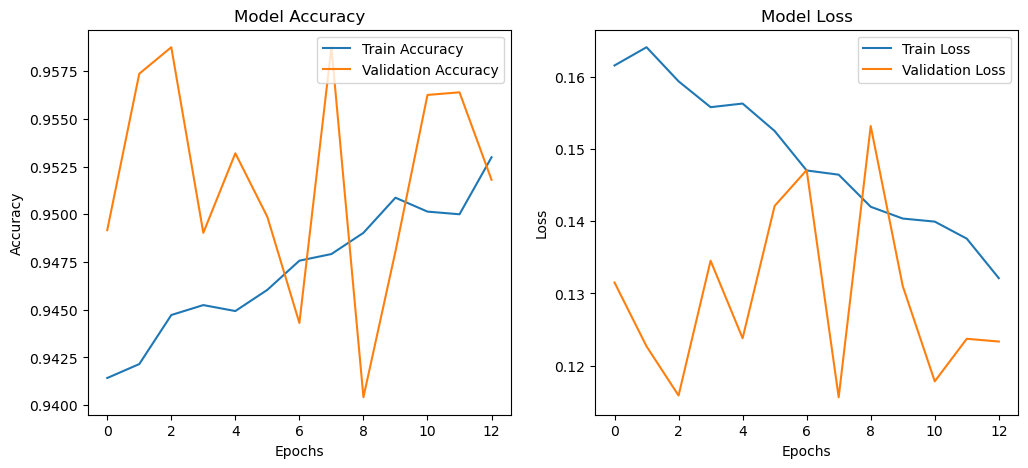

In [56]:


# Plot accuracy and loss curves
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend()

    plt.show()

# Display training performance
plot_history(history)

In [21]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9602 - loss: 0.1207
Test Accuracy: 95.83%


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


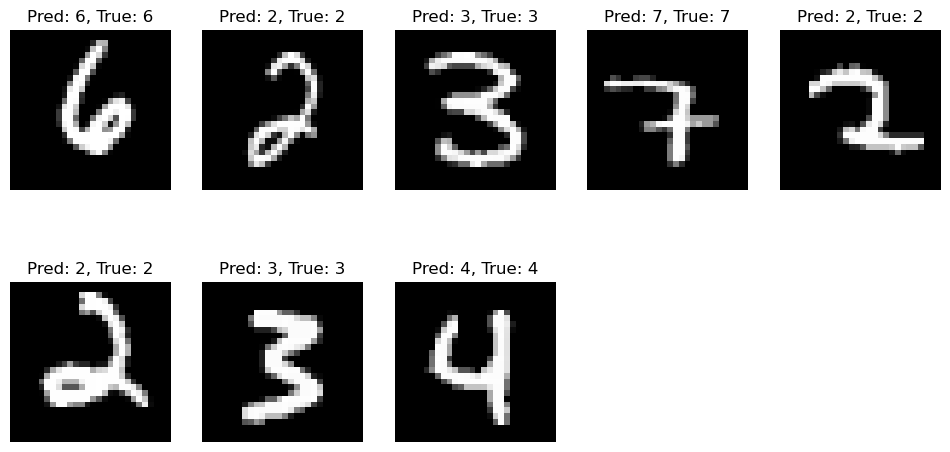

In [58]:
import matplotlib.pyplot as plt
y_pred = model.predict(x_test)  # Get predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels


# Select some test samples
num_samples = 8
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {y_pred_classes[i]}, True: {y_true_classes[i]}")
    plt.axis("off")

plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Select a random index from test data
random_idx = np.random.randint(0, len(x_test))

# Get the random test image and its true label
random_image = x_test[random_idx]
true_label = np.argmax(y_test[random_idx])  # Convert one-hot to label

# Make prediction
pred_prob = model.predict(random_image.reshape(1, 28, 28, 1))  # Reshape for prediction
pred_label = np.argmax(pred_prob)  # Get class with highest probability

# Display the image with prediction
plt.imshow(random_image.reshape(28, 28), cmap="gray")
plt.title(f"Predicted: {pred_label}, Actual: {true_label}")
plt.axis("off")
plt.show()

NameError: name 'x_test' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


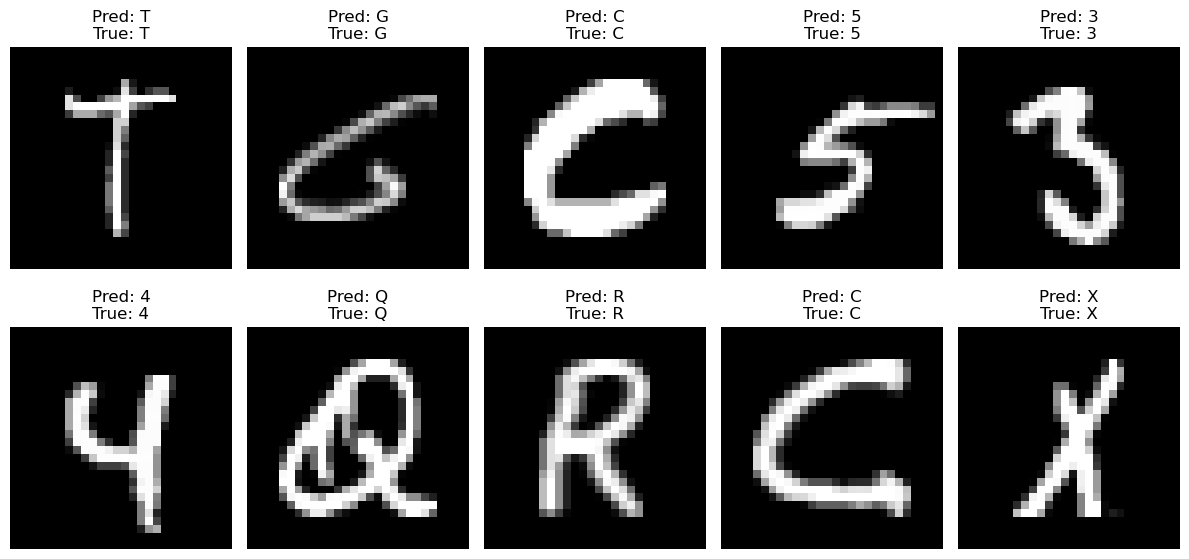

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Define mapping function for predictions
def decode_label(index):
    if index < 10:
        return str(index)  # Digits (0-9)
    else:
        return chr(index + 55)  # Convert 10-35 to A-Z (A=10 -> 'A', B=11 -> 'B', ..., Z=35 -> 'Z')

# Load the best trained model
from keras.models import load_model
model = load_model("best_model_final.keras")  # Ensure your model is saved as ".keras"

# Select random test images for prediction
num_samples = 10
random_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_sample = x_test[random_indices]
y_true = np.argmax(y_test[random_indices], axis=1)  # Convert one-hot back to label

# Predict
y_pred = model.predict(x_sample)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class indices

# Plot predictions
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {decode_label(y_pred_classes[i])}\nTrue: {decode_label(y_true[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [1]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import load_model

# Load model with error handling
try:
    model = load_model('best_model_final.keras')
except Exception as e:
    print(f"Error loading model: {str(e)}")
    exit()

In [ ]:


# Character mapping for digits (0-9) and letters (A-Z)
words = {i: str(i) for i in range(10)}  # 0-9
words.update({i + 10: chr(65 + i) for i in range(26)})  # A-Z mapped from index 10-35

# Load and process image
image_path = "I.png"  # Change to your test image
expected_character = "I"  # Expected label

image = cv2.imread(image_path)
if image is None:
    print("Error: Could not read the image.")
    exit()

# Enhanced preprocessing
image_copy = image.copy()
gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
gray_image = cv2.equalizeHist(gray_image)
img_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

# Prepare for model input
final_image = cv2.resize(img_thresh, (28, 28))
final_image = np.reshape(final_image, (1, 28, 28, 1)).astype('float32') / 255.0

# Prediction
prediction = model.predict(final_image)
predicted_index = np.argmax(prediction)
predicted_character = words[predicted_index]
confidence = np.max(prediction) * 100

# Results
result = "✅ Success" if predicted_character == expected_character else "❌ Failed"
print(f"Predicted: {predicted_character} ({confidence:.2f}%) | Expected: {expected_character} {result}")

# Visualization
display_image = image.copy()
cv2.putText(display_image, f"Pred: {predicted_character} ({confidence:.1f}%)",
           (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2.putText(display_image, f"Expected: {expected_character}",
           (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
cv2.imshow("Character Recognition", display_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
Predicted: I (97.27%) | Expected: I ✅ Success
